In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



In [0]:
from fastai import *

from fastai.vision import *
from fastai.metrics import *

In [6]:
path='/content/drive/My Drive/VIRUS'
il=ImageList.from_folder(path)
len(il)
print(il)

ImageList (746 items)
Image (3, 335, 580),Image (3, 332, 566),Image (3, 366, 612),Image (3, 551, 725),Image (3, 541, 720)
Path: /content/drive/My Drive/VIRUS


In [0]:
transforms=get_transforms(do_flip=True,max_zoom=1.1)
data=(il
.split_by_rand_pct()
.label_from_folder()
.add_test_folder())



In [0]:
data=data.transform(transforms,size=224)

In [0]:
data=data.databunch(bs=32)

In [10]:
doc(databunch)

NameError: ignored

In [11]:
ds=data.train_ds
dl=data.train_dl
print(dl)
print(type(ds))

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fdb18222080>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7fdb1ad8e7b8>)
<class 'fastai.data_block.LabelList'>


(None, Category CT_COVID)

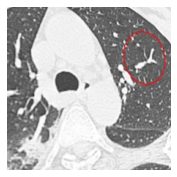

In [12]:
img,label=ds[0]
img.show(),label

['CT_COVID', 'CT_NonCOVID']


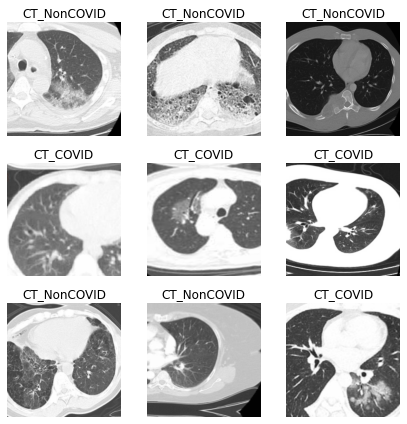

In [13]:
data.show_batch(3,figsize=(6,6),hide_axis=True)
print(data.classes)

In [14]:
learn=cnn_learner(data,models.resnet101,metrics=accuracy)
learn.fit_one_cycle(3)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.232110,1.689589,0.691275,02:57
1,1.017373,1.150676,0.711409,00:20
2,0.813847,0.751394,0.778524,00:19


In [15]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [16]:
learn.save('hsr-1')
interp=ClassificationInterpretation.from_learner(learn)
losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
print(type(interp))

<class 'fastai.train.ClassificationInterpretation'>


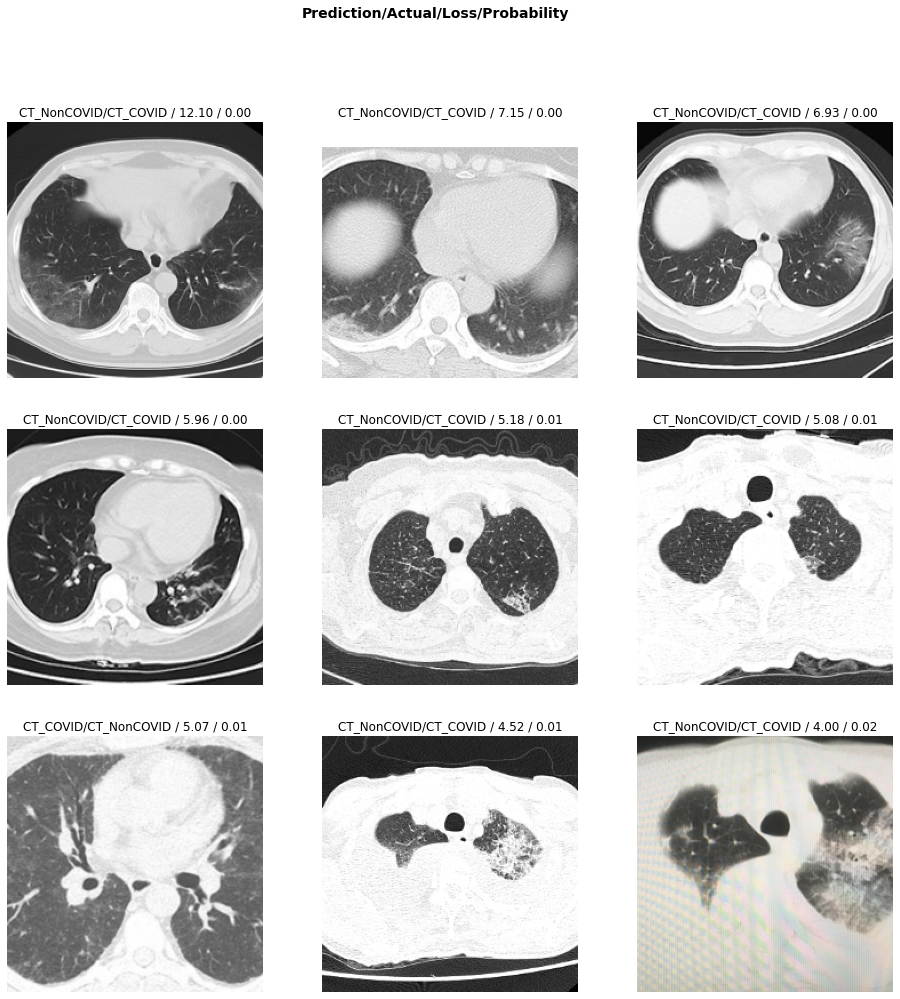

In [17]:
interp.plot_top_losses(9,figsize=(16,16))

In [18]:
learn.predict(img)

(Category CT_COVID, tensor(0), tensor([9.9978e-01, 2.2347e-04]))

[('CT_COVID', 'CT_NonCOVID', 21), ('CT_NonCOVID', 'CT_COVID', 12)]

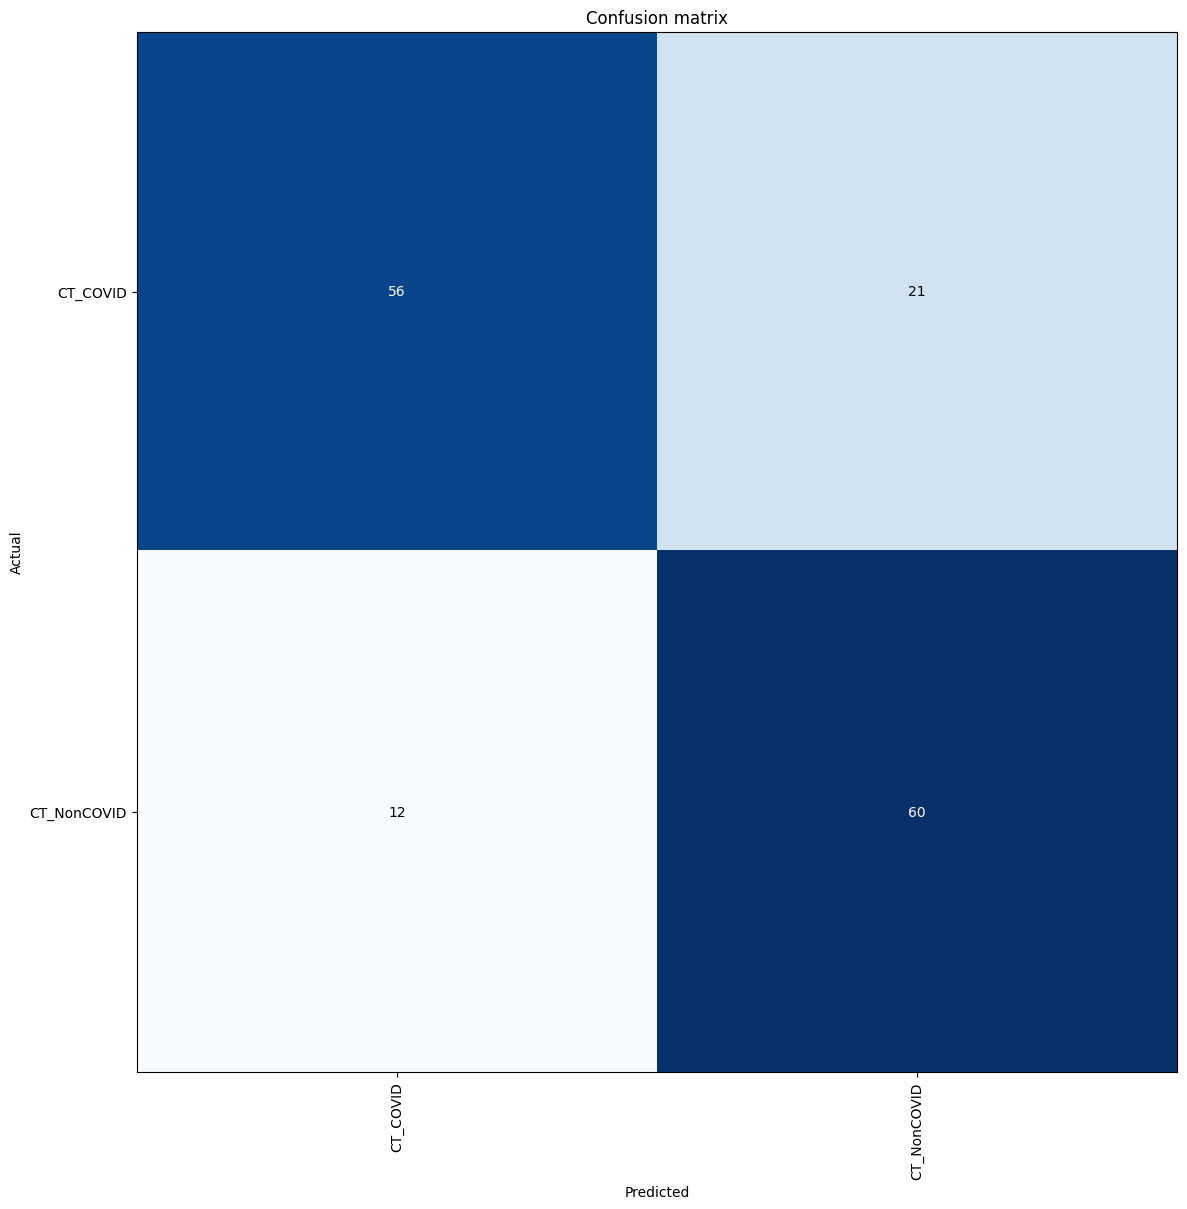

In [19]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=100)
interp.most_confused(min_val=2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.91E-05


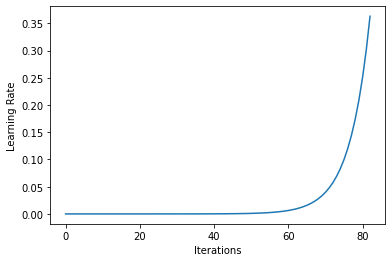

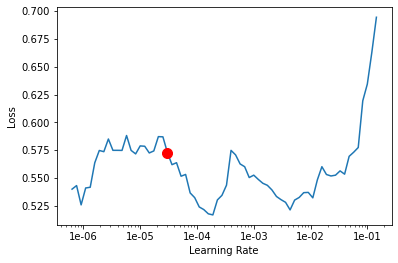

In [21]:

learn.lr_find()
learn.recorder.plot_lr()
learn.recorder.plot(suggestion=True)



In [28]:
learn.unfreeze()
learn.load('hsr-1')
learn.fit_one_cycle(10,max_lr=slice(5e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.449107,0.570385,0.818792,00:24
1,0.393819,0.407058,0.865772,00:24
2,0.362848,0.497677,0.825503,00:24
3,0.343165,0.349087,0.885906,00:24
4,0.311863,0.373300,0.892617,00:24
5,0.268853,0.313100,0.885906,00:24
6,0.229626,0.233069,0.926175,00:24
7,0.193898,0.260913,0.919463,00:24
8,0.160394,0.291068,0.932886,00:24
9,0.147352,0.270577,0.932886,00:24


In [0]:
learn.load('best_model_95.3')

In [0]:
learn.recorder.plot_lr(show_moms=True)


In [0]:
learn.recorder.plot_losses()


In [0]:
#这是Recorder的源代码
class Recorder(LearnerCallback):
    "A `LearnerCallback` that records epoch, loss, opt and metric data during training."
    _order=-10
    def __init__(self, learn:Learner, add_time:bool=True, silent:bool=False):
        super().__init__(learn)
        if not getattr(self.learn, 'opt', False): self.learn.create_opt(defaults.lr, self.learn.wd)
        self.opt = self.learn.opt
        self.train_dl = self.learn.data.train_dl
        self.no_val,self.silent,self.add_time = False,silent,add_time

    def on_train_begin(self, pbar:PBar, metrics_names:Collection[str], **kwargs:Any)->None:
        "Initialize recording status at beginning of training."
        self.pbar = pbar
        self.names = ['epoch', 'train_loss'] if self.no_val else ['epoch', 'train_loss', 'valid_loss']
        self.metrics_names = metrics_names
        if hasattr(self, '_added_met_names'): self.metrics_names += self._added_met_names
        self.names += self.metrics_names
        if self.add_time: self.names.append('time')
        if not self.silent: self.pbar.write(self.names, table=True)
        self.losses,self.val_losses,self.lrs,self.moms,self.metrics,self.nb_batches = [],[],[],[],[],[]

    def on_epoch_begin(self, **kwargs:Any)->None:
        if self.add_time: self.start_epoch = time()

    def on_batch_begin(self, train, **kwargs:Any)->None:
        "Record learning rate and momentum at beginning of batch."
        if train:
            self.lrs.append(self.opt.lr)
            self.moms.append(self.opt.mom)

    def on_backward_begin(self, smooth_loss:Tensor, **kwargs:Any)->None:
        "Record the loss before any other callback has a chance to modify it."
        self.losses.append(smooth_loss)
        if self.pbar is not None and hasattr(self.pbar,'child'):
            self.pbar.child.comment = f'{smooth_loss:.4f}'

    def on_epoch_end(self, epoch:int, num_batch:int, smooth_loss:Tensor,
                     last_metrics:MetricsList, **kwargs:Any)->bool:
        "Save epoch info: num_batch, smooth_loss, metrics."
        self.nb_batches.append(num_batch)
        if last_metrics is not None: self.val_losses.append(last_metrics[0])
        else: last_metrics = [] if self.no_val else [None]
        if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
        self.format_stats([epoch, smooth_loss] + last_metrics)

    def format_stats(self, stats:TensorOrNumList)->None:
        "Format stats before printing."
        str_stats = []
        for name,stat in zip(self.names,stats):
            str_stats.append('#na#' if stat is None else str(stat) if isinstance(stat, int) else f'{stat:.6f}')
        if self.add_time: str_stats.append(format_time(time() - self.start_epoch))
        if not self.silent: self.pbar.write(str_stats, table=True)

    def add_metric_names(self, names):
        "Add `names` to the inner metric names."
        if hasattr(self, '_added_met_names'): self._added_met_names += names
        else:                                 self._added_met_names  = names

    def plot_lr(self, show_moms=False, skip_start:int=0, skip_end:int=0, return_fig:bool=None)->Optional[plt.Figure]:
        "Plot learning rate, `show_moms` to include momentum."
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        iterations = self._split_list(range_of(self.lrs), skip_start, skip_end)
        if show_moms:
            moms = self._split_list(self.moms, skip_start, skip_end)
            fig, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, lrs)
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Learning Rate')
            axs[1].plot(iterations, moms)
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Momentum')
        else:
            fig, ax = plt.subplots()
            ax.plot(iterations, lrs)
            ax.set_xlabel('Iterations')
            ax.set_ylabel('Learning Rate')
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    @staticmethod
    def smoothen_by_spline(xs, ys, **kwargs):
        xs = np.arange(len(ys))
        spl = scipy.interpolate.UnivariateSpline(xs, ys, **kwargs)
        ys = spl(xs)
        return ys

    def plot(self, skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None,
             **kwargs)->Optional[plt.Figure]:
        "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        losses = self._split_list(self.losses, skip_start, skip_end)
        losses = [x.item() for x in losses]
        if 'k' in kwargs: losses = self.smoothen_by_spline(lrs, losses, **kwargs)
        fig, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel("Learning Rate")
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        if suggestion:
            try: mg = (np.gradient(np.array(losses))).argmin()
            except:
                print("Failed to compute the gradients, there might not be enough points.")
                return
            print(f"Min numerical gradient: {lrs[mg]:.2E}")
            ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
            self.min_grad_lr = lrs[mg]
            ml = np.argmin(losses)
            print(f"Min loss divided by 10: {lrs[ml]/10:.2E}")
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def plot_losses(self, skip_start:int=0, skip_end:int=0, return_fig:bool=None)->Optional[plt.Figure]:
        "Plot training and validation losses."
        fig, ax = plt.subplots(1,1)
        losses = self._split_list(self.losses, skip_start, skip_end)
        iterations = self._split_list(range_of(self.losses), skip_start, skip_end)
        ax.plot(iterations, losses, label='Train')
        val_iter = self._split_list_val(np.cumsum(self.nb_batches), skip_start, skip_end)
        val_losses = self._split_list_val(self.val_losses, skip_start, skip_end)
        ax.plot(val_iter, val_losses, label='Validation')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Batches processed')
        ax.legend()
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def plot_metrics(self, skip_start:int=0, skip_end:int=0, return_fig:bool=None)->Optional[plt.Figure]:
        "Plot metrics collected during training."
        assert len(self.metrics) != 0, "There are no metrics to plot."
        fig, axes = plt.subplots(len(self.metrics[0]),1,figsize=(6, 4*len(self.metrics[0])))
        val_iter = self._split_list_val(np.cumsum(self.nb_batches), skip_start, skip_end)
        axes = axes.flatten() if len(self.metrics[0]) != 1 else [axes]
        for i, ax in enumerate(axes):
            values = [met[i] for met in self.metrics]
            values = self._split_list_val(values, skip_start, skip_end)
            ax.plot(val_iter, values)
            ax.set_ylabel(str(self.metrics_names[i]))
            ax.set_xlabel('Batches processed')
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def _split_list(self, vals:Collection[float], skip_start:int, skip_end:int):
        return vals[skip_start:-skip_end] if skip_end > 0 else vals[skip_start:]

    def _split_list_val(self, vals:Collection[float], skip_start:int, skip_end:int):
        val_iter = np.cumsum(self.nb_batches)
        start_val = (val_iter - skip_start >= 0).nonzero()[0].min()
        end_val = (val_iter[-1] - val_iter - skip_end >= 0).nonzero()[0].max()+1
        return vals[start_val:end_val] if skip_end > 0 else vals[start_val:]

No handles with labels found to put in legend.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36600 missing from current font.
  font.set_text(s, 0, flags=flags)


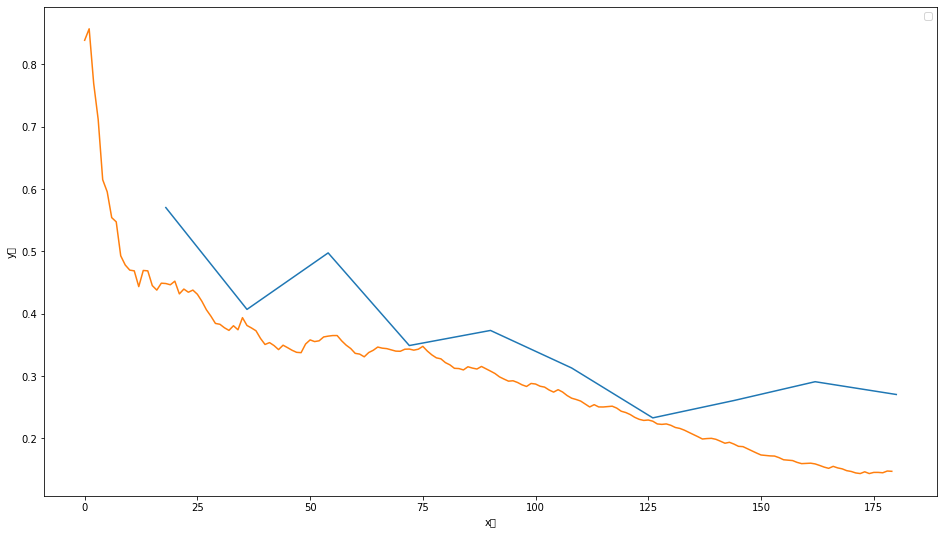

In [38]:
# learn.recorder.plot_metrics()
import numpy as np
from matplotlib.font_manager import FontProperties
val_iter=np.cumsum(learn.recorder.nb_batches)
iterations=range_of(losses)
val_losses=learn.recorder.val_losses
losses=learn.recorder.losses
len(val_iter),len(val_losses)
def plot_losses():
  fig,ax=plt.subplots(1,1,figsize=(16,9))
  ax.plot(val_iter,val_losses)
  ax.plot(iterations,losses)
  plt.xlabel("x軸",fontproperties="SimHei")
  plt.ylabel("y軸",fontproperties="SimHei") # 步驟一  （宋體）
  # # plt.title("標題", fontproperties="SimHei") #     （黑體）
  ax.legend()
  plt.show()

  # fig.savefig('result.png',dpi=600)
plot_losses()

# len(learn.recorder.val_losses),
# len(learn.recorder.losses),
# len(learn.recorder.metrics)



# 绘图大业

In [0]:
!pip install seaborn

In [0]:
import seaborn as sns
sns.set_style('whitegrid')
x1=losses
y1=

In [41]:
!pip install xlsxwriter
import xlsxwriter
import pandas as pd
result=[val_losses,losses,metrics]
result


     |████████████████████████████████| 143kB 2.7MB/s 


NameError: ignored

In [39]:
workbook=xlsxwriter.Workbook('result.xlsx')
worksheet=workbook.add_worksheet()
worksheet.write(val_losses)
worksheet.close()

NameError: ignored

In [0]:
df=pd.DataFrame({'val_losses':learn.recorder.val_losses,'losses':learn.recorder.losses,'metrics':learn.recorder.metrics})
df

# 清洗数据

In [0]:
from fastai.widgets import *


In [0]:
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]
fd = FileDeleter(file_paths=top_loss_paths)

# 对数据进行hook

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
bs=16

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data=get_data(512,bs)

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
m=learn.model.eval()
print(m)

In [0]:

xb,label=data.one_item(x)
xb_im=Image(data.denorm(xb)[0])
xb=xb.cuda()

In [0]:
from fastai.callbacks.hooks import *
def hooked_backward(cat=y):
  with hook_output(m[0]) as hook_a:
    with hook_output(m[0],grad=True) as hook_g:
      preds=m(xb)
      preds[0,int(cat)].backward()
  return hook_a,hook_g


In [0]:
hook_a,hook_g=hooked_backward()
acts=hook_a.stored[0].cpu()
acts.shape

In [0]:
avg_acts = acts.mean(0)
avg_acts.shape

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax,figsize=(8,8))
    ax.imshow(hm, alpha=0.6, extent=(0,512,512,0),
              interpolation='bilinear', cmap='magma')

In [0]:
show_heatmap(avg_acts)

In [0]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

# Grad-CAM




Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [0]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [0]:
show_heatmap(mult)

In [0]:
path

In [0]:
fn = '/content/drive/My Drive/VIRUS/CT_COVID/2020.01.24.919183-p27-135.png' #Replace with your own image

In [0]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [0]:
show_heatmap(mult)

In [0]:
data.classes[0]

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [0]:
show_heatmap(mult)